In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%pylab inline
plt.style.use("bmh")

Populating the interactive namespace from numpy and matplotlib


In [3]:
import pathlib
import pandas as pd
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_log_error
#from tqdm import tqdm
from tqdm.notebook import tqdm
from datetime import datetime

In [4]:
import numpy as np
# импортируем классы KFold, TimeSeriesSplit и GroupKFold,
# реализующие стратегии перекрестной проверки, и
# класс GridSearchCV для поиска гиперпараметров
from sklearn.model_selection import (
    KFold,
    TimeSeriesSplit, 
    GroupKFold,
    GridSearchCV
)
# увеличиваем количество отображаемых столбцов
pd.set_option('display.max_columns', 50)

In [5]:
import sklearn
print (sklearn.__version__)

1.0.1


In [6]:
DATA_DIR = pathlib.Path(".")
DATA_FILE = "sc2021_train_deals.csv"
AGG_COLS = ["material_code", "company_code", "country", "region", "manager_code"]
RS = 82736

TARGET = "target"
#start_time = datetime.now()

# Загрузка данных

In [7]:
data = pd.read_csv(DATA_DIR.joinpath(DATA_FILE), parse_dates=["month", "date"])
data

,material_code,company_code,country,region,manager_code,month,material_lvl1_name,material_lvl2_name,material_lvl3_name,contract_type,date,volume
0,134,0,Литва,Литва,12261,2018-01-01,Базовые полимеры,ПЭ,ПЭНП,Спот,2018-01-01,43.0
1,197,0,Китай,Китай,16350,2018-01-01,Базовые полимеры,ПЭ,ПЭНП,Спот,2018-01-02,95.0
2,794,2162,Казахстан,Атырауская обл.,10942,2018-01-01,Базовые полимеры,ПП,ПП,Контракт,2018-01-02,57.0
3,134,0,Литва,Литва,12261,2018-01-01,Базовые полимеры,ПЭ,ПЭНП,Спот,2018-01-02,21.0
4,133,0,Китай,Китай,17745,2018-01-01,Базовые полимеры,ПЭ,ПЭНП,Спот,2018-01-02,150.0
...,...,...,...,...,...,...,...,...,...,...,...,...
92301,134,0,Украина,Украина,18156,2020-07-01,Базовые полимеры,ПЭ,ПЭНП,Спот,2020-07-31,21.0
92302,486,0,Россия,Ростовская обл.,16156,2020-07-01,Базовые полимеры,ПП,ПП,Спот,2020-07-31,3.0
92303,276,7372,Польша,Польша,17029,2020-07-01,Базовые полимеры,ПП,ПП,Контракт,2020-07-31,25.0
92304,583,5983,Россия,Респ. Башкортостан,16788,2020-07-01,Пластики и продукты органического синтеза,ПСВ,Полистирол,Контракт,2020-07-31,21.0


# Временные ряды

In [8]:
group_ts = data.groupby(AGG_COLS + ["month"])["volume"].sum().unstack(fill_value=0)

# CatBoostRegressor

Признаки:

- оригинальные категориальные признаки,
- месяц, для которого предсказываем,
- среднее, минимум и максимум за год,
- последние N месяцев до месяца, для которого предсказываем.



# ###########################################################################

In [9]:
def get_features_Cv(df: pd.DataFrame, month: pd.Timestamp, N=6, MDAD_1=2,  MNGR_GRP_MDAD=0) -> pd.DataFrame:
    """Calculate features for `month`."""

    start_period = month - pd.offsets.MonthBegin(N)
    end_period = month - pd.offsets.MonthBegin(1)

    df = df.loc[:, :end_period]

    features = pd.DataFrame([], index=df.index)
    features["month"] = month.month
    # формируем лаги за N месяцев
    features[[f"vol_tm{i}" for i in range(N, 0, -1)]] = df.loc[:, start_period:end_period].copy()

    ### !!!!!!!!!!!!!!   #################################################################################
    rolling = df.rolling(12, axis=1, min_periods=1)
    features = features.join(rolling.mean().iloc[:, -1].rename("last_year_avg"))
    
    # Добавление ГРУППОВЫХ скользящих средних абсолютные отклонения(MDAD)
    if MNGR_GRP_MDAD != 0:
        period = MNGR_GRP_MDAD
        df2 = df.copy()
        df2[df2.columns.to_list()] = \
                                df2.groupby(level='manager_code').transform(lambda x: x.mean())
        grp_manager_roll_mean = df2.rolling(period, axis=1, min_periods=1)
        features = \
        features.join(grp_manager_roll_mean.apply(lambda x: np.nanmedian(np.abs(x - np.nanmedian(x))) , raw=True 
                        ).iloc[:, -1].rename("MNGR_GRP_MDAD"+str(period))) 
    
    if MDAD_1 != 0:
        period = MDAD_1
        rolling = df.rolling(period, axis=1, min_periods=1)
        features = features.join( 
                        rolling.apply(lambda x: np.nanmedian(np.abs(x - np.nanmedian(x))) , raw=True 
                        ).iloc[:, -1].rename("mdad_"+str(period)) )
    '''
    if MDAD_2 != 0 and MDAD_2 != MDAD_1:
        period = MDAD_2
        rolling = df.rolling(MDAD_2, axis=1, min_periods=1)
        features = features.join( 
                        rolling.apply(lambda x: np.nanmedian(np.abs(x - np.nanmedian(x))) , raw=True 
                        ).iloc[:, -1].rename("mdad_"+str(period)) )    
                        
    ### !!!!!!!!!!!!!!   ##################################################################################
    # Cv1
    
    
    
    ##################################################################################################
    '''
    ##################################################################################################
    ##################################################################################################

    # выделяем КВАРТАЛЫ
    #features["quarter"] = month.quarter

    return features

In [10]:
cv_traine_range = pd.date_range("2019-01-01", "2020-07-01", freq="MS")

#cv_traine_range = pd.date_range("2018-07-01", "2020-07-01", freq="MS")
cv_traine_range, len(cv_traine_range)

(DatetimeIndex(['2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01',
                '2019-05-01', '2019-06-01', '2019-07-01', '2019-08-01',
                '2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01',
                '2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01',
                '2020-05-01', '2020-06-01', '2020-07-01'],
               dtype='datetime64[ns]', freq='MS'),
 19)

# ####################################################################################################

# ПОДБОР ГИПЕРПАРАМЕТРОВ ДЛЯ НОВЫХ ФИЧ И МОДЕЛЕЙ

In [11]:
%%time

full_features2 = {}

dataset_features2 = []
for target_month in tqdm(cv_traine_range):
#################################################################################################################################

    features2 = get_features_Cv(group_ts, target_month, MDAD_1=2, MNGR_GRP_MDAD=0)

#################################################################################################################################
    features2[TARGET] = group_ts[target_month]
    dataset_features2.append(features2.reset_index())
full_features2 = pd.concat(dataset_features2, ignore_index=True)

CAT_COLS = ["material_code", "company_code", "country", "region", "manager_code", "month"]
# создаем список  переменных
FTS_COLS = full_features2.columns.tolist()
FTS_COLS.remove(TARGET)
#################################################################################################################################
FTS_COLS

  0%|          | 0/19 [00:00<?, ?it/s]

CPU times: user 55.2 s, sys: 61 ms, total: 55.2 s
Wall time: 55.4 s


['material_code',
 'company_code',
 'country',
 'region',
 'manager_code',
 'month',
 'vol_tm6',
 'vol_tm5',
 'vol_tm4',
 'vol_tm3',
 'vol_tm2',
 'vol_tm1',
 'last_year_avg',
 'mdad_2']

In [12]:
#cv_features = full_features2[:-941]
cv_features = full_features2#[941:]
cv_features

,material_code,company_code,country,region,manager_code,month,vol_tm6,vol_tm5,vol_tm4,vol_tm3,vol_tm2,vol_tm1,last_year_avg,mdad_2,target
941,124,7278,Россия,Респ. Татарстан,17460,2,220.0,220.0,280.0,280.0,280.0,200.0,248.333333,40.0,200.0
942,133,0,Белоруссия,Минская обл.,10942,2,0.0,0.0,0.0,0.0,0.0,0.0,21.666667,0.0,0.0
943,133,0,Белоруссия,Могилевская обл.,10942,2,0.0,100.0,220.0,20.0,0.0,0.0,40.000000,0.0,80.0
944,133,0,Белоруссия,г. Минск,10942,2,99.0,60.0,400.0,120.0,20.0,40.0,94.916667,10.0,0.0
945,133,0,Казахстан,г. Нур-Султан,13301,2,20.0,40.0,30.0,0.0,40.0,40.0,22.500000,0.0,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17874,986,9943,Россия,Смоленская обл.,17460,7,0.0,21.0,63.0,125.0,84.0,84.0,31.416667,0.0,83.0
17875,998,0,Россия,Ленинградская обл.,18079,7,5.0,5.0,5.0,0.0,3.0,3.0,4.750000,0.0,9.0
17876,998,3380,Россия,Ленинградская обл.,14956,7,73.0,74.0,122.0,100.0,15.0,30.0,85.583333,7.5,50.0
17877,998,5410,Россия,г. Санкт-Петербург,14956,7,100.0,180.0,180.0,100.0,140.0,40.0,118.333333,50.0,0.0


In [31]:
# 18 групп - блоки по 1 наблюдению
N_timeseries = 941
start_train = 1  # 

test_size=N_timeseries #*3
#max_train_size = N_timeseries*6
n_splits= 17 #int(len(full_features2)/(test_size))-1 - start_train # 

tscv = TimeSeriesSplit(n_splits=n_splits, 
                       #max_train_size=max_train_size, 
                       test_size=test_size)

verbose =  False # True # 

In [32]:
for train_index, test_index in tscv.split(cv_features): # tscv.split(X): # tscv.split(cv_features)
    print("TRAIN: ", train_index[0],"...",train_index[-1])
    print("TEST: ", test_index[0],"...",test_index[-1])

    X_train, X_test = cv_features.iloc[train_index], cv_features.iloc[test_index]
    y_train, y_test = cv_features.iloc[train_index][TARGET], cv_features.iloc[test_index][TARGET]
    
    print('Обучающий набор: %f' % (len(X_train)/941)) #test_size))
    print('Тестовый набор: %d' % (len(X_test)/941)) #test_size))

    #display(X_train)
    display(X_test)
print("tscv.get_n_splits()=",tscv.get_n_splits())

TRAIN:  0 ... 940
TEST:  941 ... 1881
Обучающий набор: 1.000000
Тестовый набор: 1


,material_code,company_code,country,region,manager_code,month,vol_tm6,vol_tm5,vol_tm4,vol_tm3,vol_tm2,vol_tm1,last_year_avg,mdad_2,target
1882,124,7278,Россия,Респ. Татарстан,17460,3,220.0,280.0,280.0,280.0,200.0,200.0,236.666667,0.0,200.0
1883,133,0,Белоруссия,Минская обл.,10942,3,0.0,0.0,0.0,0.0,0.0,0.0,21.666667,0.0,0.0
1884,133,0,Белоруссия,Могилевская обл.,10942,3,100.0,220.0,20.0,0.0,0.0,80.0,46.666667,40.0,142.0
1885,133,0,Белоруссия,г. Минск,10942,3,60.0,400.0,120.0,20.0,40.0,0.0,93.250000,20.0,0.0
1886,133,0,Казахстан,г. Нур-Султан,13301,3,40.0,30.0,0.0,40.0,40.0,50.0,26.666667,5.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2818,986,9943,Россия,Смоленская обл.,17460,3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2819,998,0,Россия,Ленинградская обл.,18079,3,5.0,5.0,0.0,0.0,5.0,5.0,2.000000,0.0,0.0
2820,998,3380,Россия,Ленинградская обл.,14956,3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,80.0
2821,998,5410,Россия,г. Санкт-Петербург,14956,3,80.0,80.0,80.0,100.0,120.0,119.0,88.250000,0.5,160.0


TRAIN:  0 ... 1881
TEST:  1882 ... 2822
Обучающий набор: 2.000000
Тестовый набор: 1


,material_code,company_code,country,region,manager_code,month,vol_tm6,vol_tm5,vol_tm4,vol_tm3,vol_tm2,vol_tm1,last_year_avg,mdad_2,target
2823,124,7278,Россия,Респ. Татарстан,17460,4,280.0,280.0,280.0,200.0,200.0,200.0,231.666667,0.0,185.0
2824,133,0,Белоруссия,Минская обл.,10942,4,0.0,0.0,0.0,0.0,0.0,0.0,21.666667,0.0,36.0
2825,133,0,Белоруссия,Могилевская обл.,10942,4,220.0,20.0,0.0,0.0,80.0,142.0,58.500000,31.0,103.0
2826,133,0,Белоруссия,г. Минск,10942,4,400.0,120.0,20.0,40.0,0.0,0.0,93.250000,0.0,0.0
2827,133,0,Казахстан,г. Нур-Султан,13301,4,30.0,0.0,40.0,40.0,50.0,0.0,24.166667,25.0,40.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3759,986,9943,Россия,Смоленская обл.,17460,4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3760,998,0,Россия,Ленинградская обл.,18079,4,5.0,0.0,0.0,5.0,5.0,0.0,2.000000,2.5,8.0
3761,998,3380,Россия,Ленинградская обл.,14956,4,0.0,0.0,0.0,0.0,0.0,80.0,6.666667,40.0,94.0
3762,998,5410,Россия,г. Санкт-Петербург,14956,4,80.0,80.0,100.0,120.0,119.0,160.0,93.250000,20.5,120.0


TRAIN:  0 ... 2822
TEST:  2823 ... 3763
Обучающий набор: 3.000000
Тестовый набор: 1


,material_code,company_code,country,region,manager_code,month,vol_tm6,vol_tm5,vol_tm4,vol_tm3,vol_tm2,vol_tm1,last_year_avg,mdad_2,target
3764,124,7278,Россия,Респ. Татарстан,17460,5,280.0,280.0,200.0,200.0,200.0,185.0,227.083333,7.5,103.0
3765,133,0,Белоруссия,Минская обл.,10942,5,0.0,0.0,0.0,0.0,0.0,36.0,8.000000,18.0,98.0
3766,133,0,Белоруссия,Могилевская обл.,10942,5,20.0,0.0,0.0,80.0,142.0,103.0,67.083333,19.5,145.0
3767,133,0,Белоруссия,г. Минск,10942,5,120.0,20.0,40.0,0.0,0.0,0.0,93.250000,0.0,0.0
3768,133,0,Казахстан,г. Нур-Султан,13301,5,0.0,40.0,40.0,50.0,0.0,40.0,25.000000,20.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4700,986,9943,Россия,Смоленская обл.,17460,5,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4701,998,0,Россия,Ленинградская обл.,18079,5,0.0,0.0,5.0,5.0,0.0,8.0,2.666667,4.0,5.0
4702,998,3380,Россия,Ленинградская обл.,14956,5,0.0,0.0,0.0,0.0,80.0,94.0,14.500000,7.0,127.0
4703,998,5410,Россия,г. Санкт-Петербург,14956,5,80.0,100.0,120.0,119.0,160.0,120.0,98.250000,20.0,140.0


TRAIN:  0 ... 3763
TEST:  3764 ... 4704
Обучающий набор: 4.000000
Тестовый набор: 1


,material_code,company_code,country,region,manager_code,month,vol_tm6,vol_tm5,vol_tm4,vol_tm3,vol_tm2,vol_tm1,last_year_avg,mdad_2,target
4705,124,7278,Россия,Респ. Татарстан,17460,6,280.0,200.0,200.0,200.0,185.0,103.0,217.333333,41.0,62.0
4706,133,0,Белоруссия,Минская обл.,10942,6,0.0,0.0,0.0,0.0,36.0,98.0,11.166667,31.0,82.0
4707,133,0,Белоруссия,Могилевская обл.,10942,6,0.0,0.0,80.0,142.0,103.0,145.0,67.500000,21.0,0.0
4708,133,0,Белоруссия,г. Минск,10942,6,20.0,40.0,0.0,0.0,0.0,0.0,89.916667,0.0,0.0
4709,133,0,Казахстан,г. Нур-Султан,13301,6,40.0,40.0,50.0,0.0,40.0,0.0,25.000000,20.0,40.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5641,986,9943,Россия,Смоленская обл.,17460,6,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
5642,998,0,Россия,Ленинградская обл.,18079,6,0.0,5.0,5.0,0.0,8.0,5.0,3.083333,1.5,10.0
5643,998,3380,Россия,Ленинградская обл.,14956,6,0.0,0.0,0.0,80.0,94.0,127.0,25.083333,16.5,121.0
5644,998,5410,Россия,г. Санкт-Петербург,14956,6,100.0,120.0,119.0,160.0,120.0,140.0,104.916667,10.0,100.0


TRAIN:  0 ... 4704
TEST:  4705 ... 5645
Обучающий набор: 5.000000
Тестовый набор: 1


,material_code,company_code,country,region,manager_code,month,vol_tm6,vol_tm5,vol_tm4,vol_tm3,vol_tm2,vol_tm1,last_year_avg,mdad_2,target
5646,124,7278,Россия,Респ. Татарстан,17460,7,200.0,200.0,200.0,185.0,103.0,62.0,204.166667,20.5,0.0
5647,133,0,Белоруссия,Минская обл.,10942,7,0.0,0.0,0.0,36.0,98.0,82.0,18.000000,8.0,62.0
5648,133,0,Белоруссия,Могилевская обл.,10942,7,0.0,80.0,142.0,103.0,145.0,0.0,67.500000,72.5,0.0
5649,133,0,Белоруссия,г. Минск,10942,7,40.0,0.0,0.0,0.0,0.0,0.0,76.583333,0.0,0.0
5650,133,0,Казахстан,г. Нур-Султан,13301,7,40.0,50.0,0.0,40.0,0.0,40.0,28.333333,20.0,40.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6582,986,9943,Россия,Смоленская обл.,17460,7,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
6583,998,0,Россия,Ленинградская обл.,18079,7,5.0,5.0,0.0,8.0,5.0,10.0,3.916667,2.5,5.0
6584,998,3380,Россия,Ленинградская обл.,14956,7,0.0,0.0,80.0,94.0,127.0,121.0,35.166667,3.0,121.0
6585,998,5410,Россия,г. Санкт-Петербург,14956,7,120.0,119.0,160.0,120.0,140.0,100.0,106.583333,20.0,120.0


TRAIN:  0 ... 5645
TEST:  5646 ... 6586
Обучающий набор: 6.000000
Тестовый набор: 1


,material_code,company_code,country,region,manager_code,month,vol_tm6,vol_tm5,vol_tm4,vol_tm3,vol_tm2,vol_tm1,last_year_avg,mdad_2,target
6587,124,7278,Россия,Респ. Татарстан,17460,8,200.0,200.0,185.0,103.0,62.0,0.0,185.833333,31.0,0.0
6588,133,0,Белоруссия,Минская обл.,10942,8,0.0,0.0,36.0,98.0,82.0,62.0,23.166667,10.0,145.0
6589,133,0,Белоруссия,Могилевская обл.,10942,8,80.0,142.0,103.0,145.0,0.0,0.0,67.500000,0.0,0.0
6590,133,0,Белоруссия,г. Минск,10942,8,0.0,0.0,0.0,0.0,0.0,0.0,61.583333,0.0,41.0
6591,133,0,Казахстан,г. Нур-Султан,13301,8,50.0,0.0,40.0,0.0,40.0,40.0,28.333333,0.0,40.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7523,986,9943,Россия,Смоленская обл.,17460,8,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
7524,998,0,Россия,Ленинградская обл.,18079,8,5.0,0.0,8.0,5.0,10.0,5.0,4.333333,2.5,5.0
7525,998,3380,Россия,Ленинградская обл.,14956,8,0.0,80.0,94.0,127.0,121.0,121.0,45.250000,0.0,129.0
7526,998,5410,Россия,г. Санкт-Петербург,14956,8,119.0,160.0,120.0,140.0,100.0,120.0,109.916667,10.0,120.0


TRAIN:  0 ... 6586
TEST:  6587 ... 7527
Обучающий набор: 7.000000
Тестовый набор: 1


,material_code,company_code,country,region,manager_code,month,vol_tm6,vol_tm5,vol_tm4,vol_tm3,vol_tm2,vol_tm1,last_year_avg,mdad_2,target
7528,124,7278,Россия,Респ. Татарстан,17460,9,200.0,185.0,103.0,62.0,0.0,0.0,167.500000,0.0,0.0
7529,133,0,Белоруссия,Минская обл.,10942,9,0.0,36.0,98.0,82.0,62.0,145.0,35.250000,41.5,124.0
7530,133,0,Белоруссия,Могилевская обл.,10942,9,142.0,103.0,145.0,0.0,0.0,0.0,67.500000,0.0,0.0
7531,133,0,Белоруссия,г. Минск,10942,9,0.0,0.0,0.0,0.0,0.0,41.0,56.750000,20.5,83.0
7532,133,0,Казахстан,г. Нур-Султан,13301,9,0.0,40.0,0.0,40.0,40.0,40.0,30.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8464,986,9943,Россия,Смоленская обл.,17460,9,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
8465,998,0,Россия,Ленинградская обл.,18079,9,0.0,8.0,5.0,10.0,5.0,5.0,4.416667,0.0,10.0
8466,998,3380,Россия,Ленинградская обл.,14956,9,80.0,94.0,127.0,121.0,121.0,129.0,56.000000,4.0,117.0
8467,998,5410,Россия,г. Санкт-Петербург,14956,9,160.0,120.0,140.0,100.0,120.0,120.0,111.583333,0.0,80.0


TRAIN:  0 ... 7527
TEST:  7528 ... 8468
Обучающий набор: 8.000000
Тестовый набор: 1


,material_code,company_code,country,region,manager_code,month,vol_tm6,vol_tm5,vol_tm4,vol_tm3,vol_tm2,vol_tm1,last_year_avg,mdad_2,target
8469,124,7278,Россия,Респ. Татарстан,17460,10,185.0,103.0,62.0,0.0,0.0,0.0,149.166667,0.0,0.0
8470,133,0,Белоруссия,Минская обл.,10942,10,36.0,98.0,82.0,62.0,145.0,124.0,45.583333,10.5,181.0
8471,133,0,Белоруссия,Могилевская обл.,10942,10,103.0,145.0,0.0,0.0,0.0,0.0,59.166667,0.0,0.0
8472,133,0,Белоруссия,г. Минск,10942,10,0.0,0.0,0.0,0.0,41.0,83.0,58.666667,21.0,82.0
8473,133,0,Казахстан,г. Нур-Султан,13301,10,40.0,0.0,40.0,40.0,40.0,0.0,26.666667,20.0,45.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9405,986,9943,Россия,Смоленская обл.,17460,10,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
9406,998,0,Россия,Ленинградская обл.,18079,10,8.0,5.0,10.0,5.0,5.0,10.0,4.833333,2.5,10.0
9407,998,3380,Россия,Ленинградская обл.,14956,10,94.0,127.0,121.0,121.0,129.0,117.0,65.750000,6.0,115.0
9408,998,5410,Россия,г. Санкт-Петербург,14956,10,120.0,140.0,100.0,120.0,120.0,80.0,111.583333,20.0,120.0


TRAIN:  0 ... 8468
TEST:  8469 ... 9409
Обучающий набор: 9.000000
Тестовый набор: 1


,material_code,company_code,country,region,manager_code,month,vol_tm6,vol_tm5,vol_tm4,vol_tm3,vol_tm2,vol_tm1,last_year_avg,mdad_2,target
9410,124,7278,Россия,Респ. Татарстан,17460,11,103.0,62.0,0.0,0.0,0.0,0.0,125.833333,0.0,0.0
9411,133,0,Белоруссия,Минская обл.,10942,11,98.0,82.0,62.0,145.0,124.0,181.0,60.666667,28.5,208.0
9412,133,0,Белоруссия,Могилевская обл.,10942,11,145.0,0.0,0.0,0.0,0.0,0.0,40.833333,0.0,0.0
9413,133,0,Белоруссия,г. Минск,10942,11,0.0,0.0,0.0,41.0,83.0,82.0,32.166667,0.5,42.0
9414,133,0,Казахстан,г. Нур-Султан,13301,11,0.0,40.0,40.0,40.0,0.0,45.0,27.916667,22.5,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10346,986,9943,Россия,Смоленская обл.,17460,11,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
10347,998,0,Россия,Ленинградская обл.,18079,11,5.0,10.0,5.0,5.0,10.0,10.0,5.250000,0.0,0.0
10348,998,3380,Россия,Ленинградская обл.,14956,11,127.0,121.0,121.0,129.0,117.0,115.0,75.333333,1.0,102.0
10349,998,5410,Россия,г. Санкт-Петербург,14956,11,140.0,100.0,120.0,120.0,80.0,120.0,114.916667,20.0,140.0


TRAIN:  0 ... 9409
TEST:  9410 ... 10350
Обучающий набор: 10.000000
Тестовый набор: 1


,material_code,company_code,country,region,manager_code,month,vol_tm6,vol_tm5,vol_tm4,vol_tm3,vol_tm2,vol_tm1,last_year_avg,mdad_2,target
10351,124,7278,Россия,Респ. Татарстан,17460,12,62.0,0.0,0.0,0.0,0.0,0.0,102.500000,0.0,0.0
10352,133,0,Белоруссия,Минская обл.,10942,12,82.0,62.0,145.0,124.0,181.0,208.0,78.000000,13.5,207.0
10353,133,0,Белоруссия,Могилевская обл.,10942,12,0.0,0.0,0.0,0.0,0.0,0.0,39.166667,0.0,0.0
10354,133,0,Белоруссия,г. Минск,10942,12,0.0,0.0,41.0,83.0,82.0,42.0,25.666667,20.0,0.0
10355,133,0,Казахстан,г. Нур-Султан,13301,12,40.0,40.0,40.0,0.0,45.0,50.0,32.083333,2.5,45.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11287,986,9943,Россия,Смоленская обл.,17460,12,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
11288,998,0,Россия,Ленинградская обл.,18079,12,10.0,5.0,5.0,10.0,10.0,0.0,5.250000,5.0,6.0
11289,998,3380,Россия,Ленинградская обл.,14956,12,121.0,121.0,129.0,117.0,115.0,102.0,83.833333,6.5,29.0
11290,998,5410,Россия,г. Санкт-Петербург,14956,12,100.0,120.0,120.0,80.0,120.0,140.0,119.916667,10.0,100.0


TRAIN:  0 ... 10350
TEST:  10351 ... 11291
Обучающий набор: 11.000000
Тестовый набор: 1


,material_code,company_code,country,region,manager_code,month,vol_tm6,vol_tm5,vol_tm4,vol_tm3,vol_tm2,vol_tm1,last_year_avg,mdad_2,target
11292,124,7278,Россия,Респ. Татарстан,17460,1,0.0,0.0,0.0,0.0,0.0,0.0,79.166667,0.0,0.0
11293,133,0,Белоруссия,Минская обл.,10942,1,62.0,145.0,124.0,181.0,208.0,207.0,95.250000,0.5,17.0
11294,133,0,Белоруссия,Могилевская обл.,10942,1,0.0,0.0,0.0,0.0,0.0,0.0,39.166667,0.0,0.0
11295,133,0,Белоруссия,г. Минск,10942,1,0.0,41.0,83.0,82.0,42.0,0.0,24.000000,21.0,0.0
11296,133,0,Казахстан,г. Нур-Султан,13301,1,40.0,40.0,0.0,45.0,50.0,45.0,32.500000,2.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12228,986,9943,Россия,Смоленская обл.,17460,1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
12229,998,0,Россия,Ленинградская обл.,18079,1,5.0,5.0,10.0,10.0,0.0,6.0,5.750000,3.0,5.0
12230,998,3380,Россия,Ленинградская обл.,14956,1,121.0,129.0,117.0,115.0,102.0,29.0,86.250000,36.5,73.0
12231,998,5410,Россия,г. Санкт-Петербург,14956,1,120.0,120.0,80.0,120.0,140.0,100.0,119.916667,20.0,100.0


TRAIN:  0 ... 11291
TEST:  11292 ... 12232
Обучающий набор: 12.000000
Тестовый набор: 1


,material_code,company_code,country,region,manager_code,month,vol_tm6,vol_tm5,vol_tm4,vol_tm3,vol_tm2,vol_tm1,last_year_avg,mdad_2,target
12233,124,7278,Россия,Респ. Татарстан,17460,2,0.0,0.0,0.0,0.0,0.0,0.0,62.500000,0.0,0.0
12234,133,0,Белоруссия,Минская обл.,10942,2,145.0,124.0,181.0,208.0,207.0,17.0,96.666667,95.0,72.0
12235,133,0,Белоруссия,Могилевская обл.,10942,2,0.0,0.0,0.0,0.0,0.0,0.0,39.166667,0.0,0.0
12236,133,0,Белоруссия,г. Минск,10942,2,41.0,83.0,82.0,42.0,0.0,0.0,20.666667,0.0,0.0
12237,133,0,Казахстан,г. Нур-Султан,13301,2,40.0,0.0,45.0,50.0,45.0,0.0,29.166667,22.5,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13169,986,9943,Россия,Смоленская обл.,17460,2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,21.0
13170,998,0,Россия,Ленинградская обл.,18079,2,5.0,10.0,10.0,0.0,6.0,5.0,5.750000,0.5,5.0
13171,998,3380,Россия,Ленинградская обл.,14956,2,129.0,117.0,115.0,102.0,29.0,73.0,92.333333,22.0,74.0
13172,998,5410,Россия,г. Санкт-Петербург,14956,2,120.0,80.0,120.0,140.0,100.0,100.0,118.250000,0.0,180.0


TRAIN:  0 ... 12232
TEST:  12233 ... 13173
Обучающий набор: 13.000000
Тестовый набор: 1


,material_code,company_code,country,region,manager_code,month,vol_tm6,vol_tm5,vol_tm4,vol_tm3,vol_tm2,vol_tm1,last_year_avg,mdad_2,target
13174,124,7278,Россия,Респ. Татарстан,17460,3,0.0,0.0,0.0,0.0,0.0,0.0,45.833333,0.0,0.0
13175,133,0,Белоруссия,Минская обл.,10942,3,124.0,181.0,208.0,207.0,17.0,72.0,102.666667,27.5,250.0
13176,133,0,Белоруссия,Могилевская обл.,10942,3,0.0,0.0,0.0,0.0,0.0,0.0,32.500000,0.0,0.0
13177,133,0,Белоруссия,г. Минск,10942,3,83.0,82.0,42.0,0.0,0.0,0.0,20.666667,0.0,0.0
13178,133,0,Казахстан,г. Нур-Султан,13301,3,0.0,45.0,50.0,45.0,0.0,50.0,29.166667,25.0,40.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14110,986,9943,Россия,Смоленская обл.,17460,3,0.0,0.0,0.0,0.0,0.0,21.0,1.750000,10.5,63.0
14111,998,0,Россия,Ленинградская обл.,18079,3,10.0,10.0,0.0,6.0,5.0,5.0,5.750000,0.0,5.0
14112,998,3380,Россия,Ленинградская обл.,14956,3,117.0,115.0,102.0,29.0,73.0,74.0,98.500000,0.5,122.0
14113,998,5410,Россия,г. Санкт-Петербург,14956,3,80.0,120.0,140.0,100.0,100.0,180.0,123.333333,40.0,180.0


TRAIN:  0 ... 13173
TEST:  13174 ... 14114
Обучающий набор: 14.000000
Тестовый набор: 1


,material_code,company_code,country,region,manager_code,month,vol_tm6,vol_tm5,vol_tm4,vol_tm3,vol_tm2,vol_tm1,last_year_avg,mdad_2,target
14115,124,7278,Россия,Респ. Татарстан,17460,4,0.0,0.0,0.0,0.0,0.0,0.0,29.166667,0.0,0.0
14116,133,0,Белоруссия,Минская обл.,10942,4,181.0,208.0,207.0,17.0,72.0,250.0,123.500000,89.0,394.0
14117,133,0,Белоруссия,Могилевская обл.,10942,4,0.0,0.0,0.0,0.0,0.0,0.0,20.666667,0.0,166.0
14118,133,0,Белоруссия,г. Минск,10942,4,82.0,42.0,0.0,0.0,0.0,0.0,20.666667,0.0,21.0
14119,133,0,Казахстан,г. Нур-Султан,13301,4,45.0,50.0,45.0,0.0,50.0,40.0,32.500000,5.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15051,986,9943,Россия,Смоленская обл.,17460,4,0.0,0.0,0.0,0.0,21.0,63.0,7.000000,21.0,125.0
15052,998,0,Россия,Ленинградская обл.,18079,4,10.0,0.0,6.0,5.0,5.0,5.0,6.166667,0.0,0.0
15053,998,3380,Россия,Ленинградская обл.,14956,4,115.0,102.0,29.0,73.0,74.0,122.0,102.000000,24.0,100.0
15054,998,5410,Россия,г. Санкт-Петербург,14956,4,120.0,140.0,100.0,100.0,180.0,180.0,125.000000,0.0,100.0


TRAIN:  0 ... 14114
TEST:  14115 ... 15055
Обучающий набор: 15.000000
Тестовый набор: 1


,material_code,company_code,country,region,manager_code,month,vol_tm6,vol_tm5,vol_tm4,vol_tm3,vol_tm2,vol_tm1,last_year_avg,mdad_2,target
15056,124,7278,Россия,Респ. Татарстан,17460,5,0.0,0.0,0.0,0.0,0.0,0.0,13.750000,0.0,0.0
15057,133,0,Белоруссия,Минская обл.,10942,5,208.0,207.0,17.0,72.0,250.0,394.0,153.333333,72.0,288.0
15058,133,0,Белоруссия,Могилевская обл.,10942,5,0.0,0.0,0.0,0.0,0.0,166.0,25.916667,83.0,62.0
15059,133,0,Белоруссия,г. Минск,10942,5,42.0,0.0,0.0,0.0,0.0,21.0,22.416667,10.5,0.0
15060,133,0,Казахстан,г. Нур-Султан,13301,5,50.0,45.0,0.0,50.0,40.0,0.0,29.166667,20.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15992,986,9943,Россия,Смоленская обл.,17460,5,0.0,0.0,0.0,21.0,63.0,125.0,17.416667,31.0,84.0
15993,998,0,Россия,Ленинградская обл.,18079,5,0.0,6.0,5.0,5.0,5.0,0.0,5.500000,2.5,3.0
15994,998,3380,Россия,Ленинградская обл.,14956,5,102.0,29.0,73.0,74.0,122.0,100.0,102.500000,11.0,15.0
15995,998,5410,Россия,г. Санкт-Петербург,14956,5,140.0,100.0,100.0,180.0,180.0,100.0,123.333333,40.0,140.0


TRAIN:  0 ... 15055
TEST:  15056 ... 15996
Обучающий набор: 16.000000
Тестовый набор: 1


,material_code,company_code,country,region,manager_code,month,vol_tm6,vol_tm5,vol_tm4,vol_tm3,vol_tm2,vol_tm1,last_year_avg,mdad_2,target
15997,124,7278,Россия,Респ. Татарстан,17460,6,0.0,0.0,0.0,0.0,0.0,0.0,5.166667,0.0,0.0
15998,133,0,Белоруссия,Минская обл.,10942,6,207.0,17.0,72.0,250.0,394.0,288.0,169.166667,53.0,210.0
15999,133,0,Белоруссия,Могилевская обл.,10942,6,0.0,0.0,0.0,0.0,166.0,62.0,19.000000,52.0,0.0
16000,133,0,Белоруссия,г. Минск,10942,6,0.0,0.0,0.0,0.0,21.0,0.0,22.416667,10.5,0.0
16001,133,0,Казахстан,г. Нур-Султан,13301,6,45.0,0.0,50.0,40.0,0.0,0.0,29.166667,0.0,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16933,986,9943,Россия,Смоленская обл.,17460,6,0.0,0.0,21.0,63.0,125.0,84.0,24.416667,20.5,84.0
16934,998,0,Россия,Ленинградская обл.,18079,6,6.0,5.0,5.0,5.0,0.0,3.0,5.333333,1.5,3.0
16935,998,3380,Россия,Ленинградская обл.,14956,6,29.0,73.0,74.0,122.0,100.0,15.0,93.166667,42.5,30.0
16936,998,5410,Россия,г. Санкт-Петербург,14956,6,100.0,100.0,180.0,180.0,100.0,140.0,123.333333,20.0,40.0


TRAIN:  0 ... 15996
TEST:  15997 ... 16937
Обучающий набор: 17.000000
Тестовый набор: 1


,material_code,company_code,country,region,manager_code,month,vol_tm6,vol_tm5,vol_tm4,vol_tm3,vol_tm2,vol_tm1,last_year_avg,mdad_2,target
16938,124,7278,Россия,Респ. Татарстан,17460,7,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
16939,133,0,Белоруссия,Минская обл.,10942,7,17.0,72.0,250.0,394.0,288.0,210.0,179.833333,39.0,249.0
16940,133,0,Белоруссия,Могилевская обл.,10942,7,0.0,0.0,0.0,166.0,62.0,0.0,19.000000,31.0,0.0
16941,133,0,Белоруссия,г. Минск,10942,7,0.0,0.0,0.0,21.0,0.0,0.0,22.416667,0.0,6.0
16942,133,0,Казахстан,г. Нур-Султан,13301,7,0.0,50.0,40.0,0.0,0.0,50.0,30.000000,25.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17874,986,9943,Россия,Смоленская обл.,17460,7,0.0,21.0,63.0,125.0,84.0,84.0,31.416667,0.0,83.0
17875,998,0,Россия,Ленинградская обл.,18079,7,5.0,5.0,5.0,0.0,3.0,3.0,4.750000,0.0,9.0
17876,998,3380,Россия,Ленинградская обл.,14956,7,73.0,74.0,122.0,100.0,15.0,30.0,85.583333,7.5,50.0
17877,998,5410,Россия,г. Санкт-Петербург,14956,7,100.0,180.0,180.0,100.0,140.0,40.0,118.333333,50.0,0.0


tscv.get_n_splits()= 17


In [ ]:
%%time
from datetime import datetime
start_time = datetime.now()


ITERATION = 59 
LEARNING_RATE = 0.07
DEPTH = 4 
# 'L2_leaf_reg=>', 17, 'Border_count=>', 64, 'Bagging_temperature', None,
#L2_leaf_reg = 17
#Border_count = 64
#Bagging_temperature = None

RANG_ITERATION = [52] #range(20,100, 1) # range(20,1500, 5) 
RANG_LEARNING_RATE= [0.079] #list(np.arange(0.076,0.084,0.001)) # [0.071] #list(np.arange(0.06,0.09,0.001)) # [0.025] #list(np.arange(0.01,0.1,0.005)) # [0.08] #   [0.066822] # [0.08] # list(np.arange(0.005,0.1,0.005)) # 
RANG_DEPTH = range(1, 8, 1) #[3,4,5,6] # [4] #  range(1, 8, 1)

#L2_leaf_reg_RANG = range(3, 30, 1) # [3] #  #range(3, 30, 1)
#Border_count_RANG = (64, 512, 64)  # [254]  # #(64, 512, 64)
#Bagging_temperature_RANG = [None] # list(np.arange(0.6,1,0.1)) + [None] ##Bagging_temperature_RANG = list(np.arange(0.6,1,0.1))

PARAMETR_1_NAME = "ITERATION"
PARAMETR_1_RANG = RANG_ITERATION

PARAMETR_2_NAME = "LEARNING_RATE"
PARAMETR_2_RANG = RANG_LEARNING_RATE

PARAMETR_3_NAME = "DEPTH"
PARAMETR_3_RANG = RANG_DEPTH

#################################################################################################################################
RMSLE_ALL = []
RMSLE_ALL_ALL = []
for PARAMETR_3 in tqdm(PARAMETR_3_RANG , position=0,  leave=False, colour='green' ):
    for PARAMETR_2 in tqdm(PARAMETR_2_RANG , position=1,  leave=False, colour='green' ):
        for PARAMETR_1 in tqdm(PARAMETR_1_RANG , position=2,  leave=False, colour='green' ):
        #for PARAMETR_1 in PARAMETR_1_RANG :
            # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
            ITERATION = PARAMETR_1
            LEARNING_RATE = PARAMETR_2
            DEPTH = PARAMETR_3

            RMSLE  = 0
            cnt=0

            #for train_index, test_index in tqdm(tscv.split(cv_features), position=3, leave=False, colour='red'):
            for train_index, test_index in tscv.split(cv_features):
                X_train, X_test = cv_features.iloc[train_index][FTS_COLS], cv_features.iloc[test_index][FTS_COLS]
                y_train, y_test = cv_features.iloc[train_index][TARGET], cv_features.iloc[test_index][TARGET]
                if verbose:
                    print("TRAIN: ", train_index[0],"...",train_index[-1])
                    print("TEST: ", test_index[0],"...",test_index[-1])
                    print('Обучающий набор: %f' % (len(X_train)/test_size))
                    print('Тестовый набор: %d' % (len(X_test)/test_size))
                    display(X_train)
                    display(X_test)
                    print('')
                model = CatBoostRegressor(iterations=ITERATION,
                                          learning_rate=LEARNING_RATE, # 0.066822,
                                          depth=DEPTH,
                                          cat_features=CAT_COLS,
                                          random_state=RS,
                                          verbose=0,
                                          
                                        #l2_leaf_reg=L2_leaf_reg,
                                        #border_count= Border_count,
                                        #bagging_temperature=Bagging_temperature
                                         
                                         )

                model.fit(X_train[FTS_COLS], 
                          ############ full_features["tr"][TARGET],
                          # обучаем модель, используя логарифмирование зависимой 
                          np.log1p(y_train))
                ts_preds = np.expm1(model.predict(X_test))
                ts_preds = pd.Series(ts_preds).clip(lower=0)
                RMSLE_i = np.sqrt(mean_squared_log_error(y_test, ts_preds))
                RMSLE_ALL_ALL.append(RMSLE_i)
                cnt+=1
                #print(cnt," Ошибка на тестовом множестве:",f'{RMSLE_i:.4f}')
                RMSLE += RMSLE_i/tscv.get_n_splits() # n_splits # 

            msg = [ RMSLE, 
                   #"L2_leaf_reg=>",L2_leaf_reg,
                   #"Border_count=>",Border_count,
                   #"Bagging_temperature",Bagging_temperature,
                   "LEARNING_RATE->",LEARNING_RATE,"ITER=>",ITERATION,"DEPTH=",DEPTH]
            RMSLE_ALL.append(msg)
            print(msg)
            RMSLE_ALL.sort(reverse=True)
            #print("Лучший результат на текущей итерации : ", RMSLE_ALL[-1])


print("\n Отсортированные результаты : \n")
for i in RMSLE_ALL:
    print(i)
print("\n Лучший результат : \n")
print(RMSLE_ALL[-1])

# do your work here
end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))

In [62]:
print(RMSLE_ALL[-1])

[1.6125325322605752, 'LEARNING_RATE->', 0.079, 'ITER=>', 52, 'DEPTH=', 3]


Зависисмость SCORE от DEPTH :


<AxesSubplot:xlabel='6'>

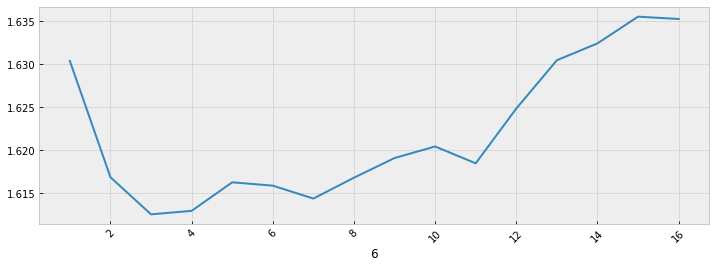

In [65]:
print("Зависисмость SCORE от DEPTH :")
plt.figure(figsize=(12,4))
pd.DataFrame(RMSLE_ALL).set_index(6).iloc[:,0].sort_index().plot(rot=45)